## Gym lunar lander

In [667]:
%config InlineBackend.figure_format = "retina"

In [111]:
import gym

In [195]:
import jax
import jax.numpy as jnp

In [646]:
import matplotlib.pyplot as plt

In [682]:
from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import base_filter

In [683]:
env = gym.make("LunarLander-v2")

In [684]:
class LinearPolicy(nn.Module):
    n_actions: int
    n_features: int
    
    @nn.compact
    def __call__(self, x):
        a = x[..., 0]
        x = x[..., 1:]
        embedding = nn.Embed(self.n_actions, self.n_features)(a.astype(int))
        x = jnp.einsum("...j,...j->...", embedding, x)
        return x

In [685]:
key = jax.random.PRNGKey(314)
X_init = jnp.ones(env.observation_space.shape[0] + 1)
model = LinearPolicy(n_actions=env.action_space.n, n_features=env.observation_space.shape[0])
params_init = model.init(key, X_init[None, :])
jax.tree.map(jnp.shape, params_init)

{'params': {'Embed_0': {'embedding': (4, 8)}}}

In [757]:
agent = lrkf.LowRankCovarianceFilter(
    model.apply,
    lambda x: jnp.eye(1) * 1.0,
    dynamics_covariance=1e-4,
    rank=32
)


# agent = base_filter.ExtendedFilter(
#     model.apply,
#     lambda x: jnp.eye(1) * 1.0,
#     dynamics_covariance=0.0
# )

@jax.jit
def sample_predictives(key, bel, state):
    state = jnp.atleast_1d(state)
    actions = jnp.arange(4)
    keys = jax.random.split(key, 4)
    @jax.vmap
    def _sample(key, action):
        X = jnp.c_[action, state]
        sample = agent.sample_predictive(key, bel_init, X)
        return sample
    samples = _sample(keys, actions)
    return samples

In [758]:
from tqdm import tqdm

In [761]:
@jax.jit
def update(bel, y, X):
    return agent.update(bel, y, X[None, :])

In [764]:
gamma = 0.9999
state_prev, _ = env.reset(seed=314)
action_prev = 0
bel_init = agent.init_bel(params_init, cov=10.0)
bel = bel_init

steps = 8_000
episode_reward = 0.0
final_rewards = []
n_episodes = 0
ewm_episode = 0.0
rewards = np.zeros(steps)

for s in (pbar := tqdm(range(steps))):
    key_t = jax.random.fold_in(key, s)
    action_value_samples = sample_predictives(key_t, bel, state_prev[None, :])
    action = action_value_samples.argmax().item()
    state_next, reward, terminated, truncated, info = env.step(action)
    
    if terminated:
        _, key_new = jax.random.split(key_t)
        state_prev, info = env.reset()
        action_value_samples = sample_predictives(key_t, bel, state_prev[None, :])
        action = action_value_samples.argmax().item()
        final_rewards.append(episode_reward)
        ewm_episode = 0.3 * episode_reward + (1 - 0.3) * ewm_episode
        pbar.set_description(f"EWM @ {n_episodes}: {ewm_episode:0.2f}")
        episode_reward = 0.0
        n_episodes += 1
        continue
    else:
        rewards[s] = reward
        episode_reward += reward
    
    X_prev = jnp.insert(state_prev, 0, jnp.array([action_prev]))
    
    X_next = jnp.insert(state_next, 0, jnp.array([action]), 0)
    y = reward + gamma * agent.mean_fn(bel.mean, X_next)
    
    state_prev = state_next
    action_prev = action
    
    # bel = agent.update(bel, y, X_next[None, :])
    # bel = agent.update(bel, bel, y, X_prev[None, :])
    bel = update(bel, y, X_prev)

EWM @ 60: -111.05: 100%|█████████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:33<00:00, 52.27it/s]


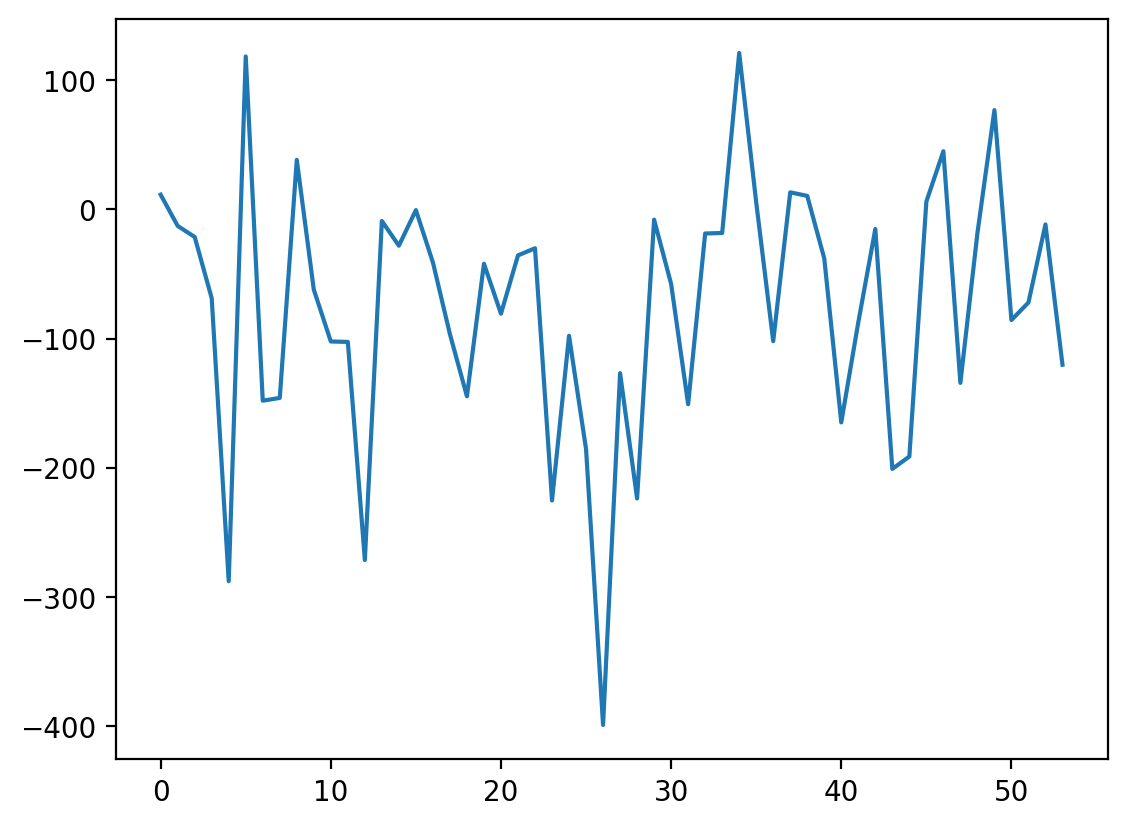

In [763]:
plt.plot(np.array(final_rewards))

In [618]:
action_value_samples = sample_predictives(key, bel, state_prev[None, :])
action = action_value_samples.argmax().item()

In [619]:
state_next, reward, terminated, truncated, info = env.step(action)

In [620]:
X_prev = jnp.insert(observation_next, 0, jnp.array([action_prev]))
yhat = agent.mean_fn(bel_init.mean, X_prev)

In [621]:
X_next = jnp.insert(observation_next, 0, jnp.array([action]), 0)
y = reward + gamma * agent.mean_fn(bel_init.mean, X_next)
state_prev = state_next

In [622]:
reward

np.float64(0.4749850519668257)